# Data Augmentation

El proceso de Data Augmentation consiste en realizar diversas transformaciones sobre los datos de entrada con el objetivo de aportar variabilidad e incrementar el tamaño de mi conjunto de datos, partiendo de los datos ya existentes y etiquetados. Dichas transformaciones puede ser, como vimos en teoria, de distintos tipos, sin embargo, es necesario tener en cuenta solo utilizar las que sean coherentes con el problema puntual sobre el que estamos trabajando.

Para este ejercicio vamos a trabajar con un dataset de imágenes de perros y gatos, el cual contiene 4000 imagenes a color, 2000 de perros y 2000 de gatos. Dichas imágenes ya se encuentran divididas en 3 carpetas correspondientes a entrenamiento, validación y testeo con 2000, 1000 y 1000 imágenes en cada una, respectivamente.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 27.3 MB/s 


Podemos descargar el dataset al entorno de trabajo, desde una carpeta de Drive a partir de utilizar el ID del archivo dentro de Drive.

In [2]:
# https://drive.google.com/file/d/1QEsn1vs35pi3AFcMzSfmZtOdfXn2AqxG/view?usp=sharing
# El ID sera: 1QEsn1vs35pi3AFcMzSfmZtOdfXn2AqxG
!gdown --id 1QEsn1vs35pi3AFcMzSfmZtOdfXn2AqxG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QEsn1vs35pi3AFcMzSfmZtOdfXn2AqxG
To: /content/perros_y_gatos.zip
100% 90.8M/90.8M [00:01<00:00, 80.5MB/s]


In [3]:
!unzip /content/perros_y_gatos.zip > /dev/null

## Visualización de los datos

A partir de observar las distintas imágenes, podemos notar que no todas conservan las mismas dimensiones, por lo que será necesario realizar un redimensionamiento de forma tal que queden uniformes para un posible entrenamiento con capas convolucionales.

(374, 500, 3)


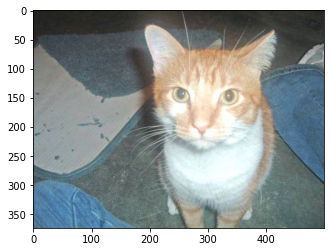

In [ ]:
import matplotlib.image as mpimg

image = mpimg.imread("train/cats/cat.128.jpg")

print(image.shape)
plt.imshow(image)

## Utilizar los datos

Para consumir los datos con nuestro modelo vamos a utilizar objetos de la clase DataLoader con la diferencia, respecto al ejemplo con MNIST, que, en este caso, las imágenes no vienen incluidas dentro de `torchvision`. Entonces, para poder cargar imágenes propias utilizamos la clase [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder), a la cual le pasamos el directorio donde se encuentran las imágenes a partir del cual infiere las clases dentro del dataset. Para mas información respecto a este punto ver [aquí](https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder).

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(150, 150)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='./train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='./validation', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='./test', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

Ahora defino una red neuronal contemplando la opción de que, si existe una GPU, se mueva la red allí para optimizar el entrenamiento.

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=2)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                    [-1, 2]           1,026
Total params: 5,407,394
Trainable params: 5,407,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.63
Estima

In [ ]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model_loss = torch.nn.CrossEntropyLoss()

conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model_optimizer.zero_grad()
    
    output = conv_model(train_data)
    
    loss = conv_model_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model_optimizer.step()

    accuracy = conv_model_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model(valid_data)
    epoch_valid_loss += conv_model_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 0.698618 - Train Accuracy 0.500496 - Valid Loss 0.692638 - Valid Accuracy 0.503000
Epoch: 2/20 - Train loss 0.693080 - Train Accuracy 0.504960 - Valid Loss 0.692584 - Valid Accuracy 0.502000
Epoch: 3/20 - Train loss 0.693719 - Train Accuracy 0.518353 - Valid Loss 0.692660 - Valid Accuracy 0.511000
Epoch: 4/20 - Train loss 0.693047 - Train Accuracy 0.516865 - Valid Loss 0.692736 - Valid Accuracy 0.528000
Epoch: 5/20 - Train loss 0.691523 - Train Accuracy 0.527778 - Valid Loss 0.689301 - Valid Accuracy 0.541000
Epoch: 6/20 - Train loss 0.689224 - Train Accuracy 0.540675 - Valid Loss 0.691526 - Valid Accuracy 0.545000
Epoch: 7/20 - Train loss 0.684050 - Train Accuracy 0.554563 - Valid Loss 0.715082 - Valid Accuracy 0.506000
Epoch: 8/20 - Train loss 0.674541 - Train Accuracy 0.586806 - Valid Loss 0.676403 - Valid Accuracy 0.566000
Epoch: 9/20 - Train loss 0.661439 - Train Accuracy 0.610615 - Valid Loss 0.685208 - Valid Accuracy 0.574000
Epoch: 10/20 - Train loss 0.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

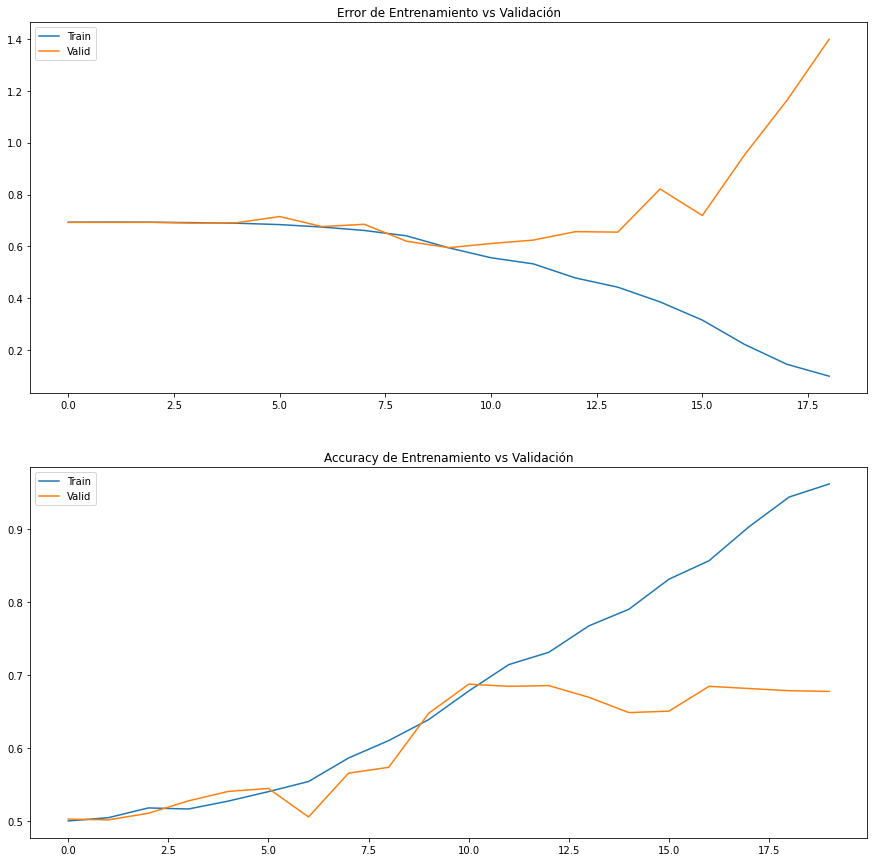

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Su puede observar una clara tendencia al sobreentrenamiento del modelo, el cual es debido a, entre otras cosas, la poca cantidad de datos de entrenamiento utilizados.

Si evaluo el modelo con el conjunto de testeo los resultados son:

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = conv_model(test_data)
  test_loss += conv_model_loss(output, test_target).item()
  test_accuracy += conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.692401 y una accuracy de 0.689000


---
## Aplicar Data Augmentation

Para aplicar Data Augmentation sobre los datos vamos a utilizar la misma composición de transformaciones que ya veniamos utilizando. Allí podemos agregar una serie de funciones listadas [`aquí`](https://pytorch.org/vision/stable/transforms.html). Para ver ejemplos de dichas transformaciones ver [este](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) link.

In [ ]:
aud_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(150, 150)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                      ])

aug_train_set = torchvision.datasets.ImageFolder(root='./train', transform=aud_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='./validation', transform=aud_data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

Podemos visualizar el resultado de aplicar dichas transformaciones sobre las imágenes de nuestro dataset. Aquí el metodo [`permute`](https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute) nos permite reordenar las dimensiones del tensor de (3, 150, 150) a (150, 150, 3).

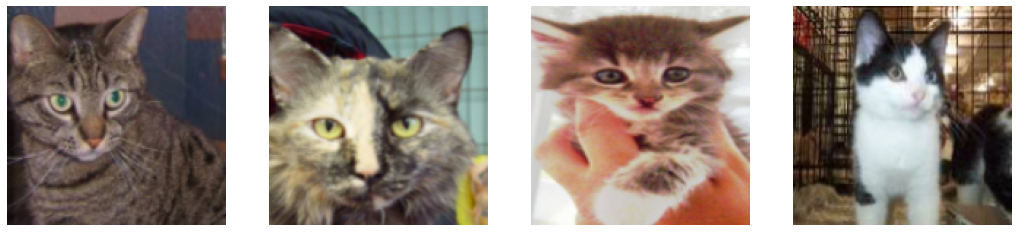

In [ ]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Si ahora, repito el proceso de entrenamiento, utilizando la misma arquitectura de red neuronal del caso anterior, pero pasandole datos sobre los que realizo las perturbaciones antes definidas, mi entrenamiento deberia ser más estable aunque un poco mas lento.

In [ ]:
aug_conv_model = ConvModel()

if torch.cuda.is_available():
  aug_conv_model = aug_conv_model.to("cuda")

aug_conv_model_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)

aug_conv_model_loss = torch.nn.CrossEntropyLoss()

aug_conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  aug_conv_model_accuracy = aug_conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 40

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_conv_model_optimizer.zero_grad()
    
    aug_output = aug_conv_model(aug_train_data)
    
    aug_loss = aug_conv_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_conv_model_optimizer.step()
    accuracy = aug_conv_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_conv_model(aug_valid_data)
    epoch_valid_loss += aug_conv_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_conv_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/40 - Train loss 0.694089 - Train Accuracy 0.497520 - Valid Loss 0.692819 - Valid Accuracy 0.605469
Epoch: 2/40 - Train loss 0.692762 - Train Accuracy 0.510417 - Valid Loss 0.692039 - Valid Accuracy 0.514648
Epoch: 3/40 - Train loss 0.692332 - Train Accuracy 0.500496 - Valid Loss 0.693933 - Valid Accuracy 0.500977
Epoch: 4/40 - Train loss 0.690431 - Train Accuracy 0.534226 - Valid Loss 0.690144 - Valid Accuracy 0.518555
Epoch: 5/40 - Train loss 0.683071 - Train Accuracy 0.575397 - Valid Loss 0.675909 - Valid Accuracy 0.583984
Epoch: 6/40 - Train loss 0.668028 - Train Accuracy 0.587798 - Valid Loss 0.665599 - Valid Accuracy 0.599609
Epoch: 7/40 - Train loss 0.663536 - Train Accuracy 0.585813 - Valid Loss 0.662271 - Valid Accuracy 0.592773
Epoch: 8/40 - Train loss 0.658628 - Train Accuracy 0.595238 - Valid Loss 0.659648 - Valid Accuracy 0.596680
Epoch: 9/40 - Train loss 0.645039 - Train Accuracy 0.619048 - Valid Loss 0.653545 - Valid Accuracy 0.614258
Epoch: 10/40 - Train loss 0.

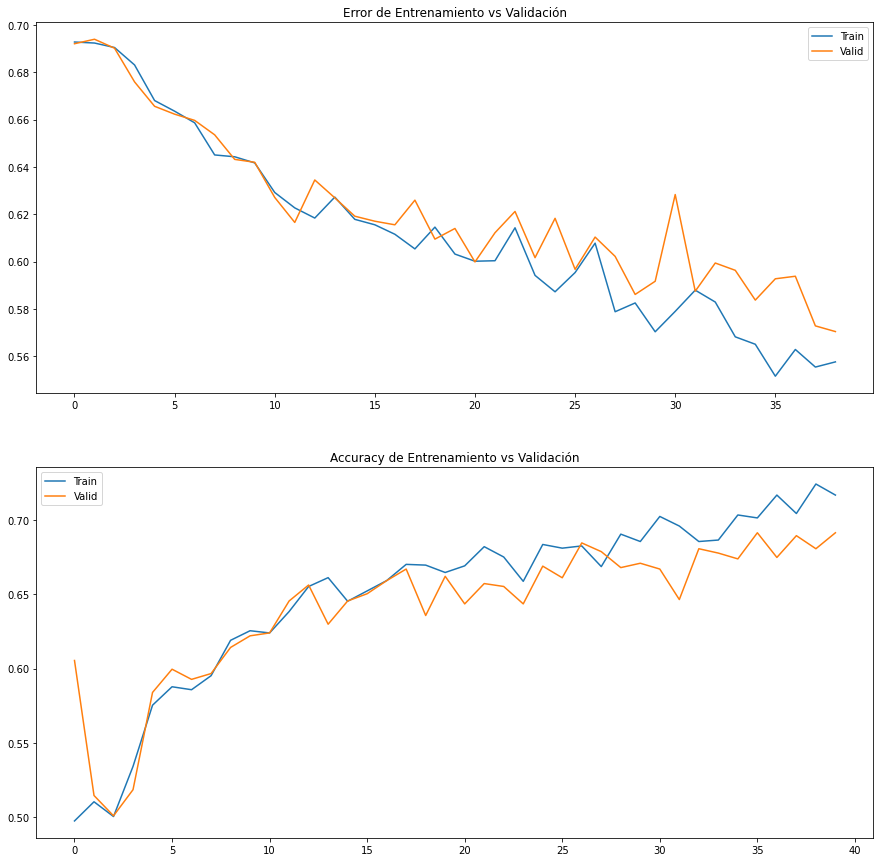

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Luego de entrenar, evaluo el modelo con los datos de testeo sin aplicarles data augmentation

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = aug_conv_model(test_data)
  test_loss += aug_conv_model_loss(output, test_target).item()
  test_accuracy += aug_conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.579392 y una accuracy de 0.691000
